# Advanced machine learning - Reinforcement Learning Exercise

### Training a DRL agent

Welcome to the exercises of reinforcement learning! In this exercise we will train two popular deep reinforcement learning agents that you have learned through your courses. This is the time to put that knowledge to practice!

In the notebook, you will see a couple of ToDos. Try your best to work through them, and don't hesitate to ask for help!

#### Import and install required libraries

In [ ]:
# install required system dependencies for visualization
!apt-get install -y xvfb x11-utils

# install required python dependencies
!pip install -q swig
!pip install -q gymnasium[box2d]

# install for the visualization of the agent
!pip install -q pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
# install stable baselines that house the RL algorithms of DQN and PPO
!pip install "stable_baselines3[extra]>=2.0.0a9"

The cell below imports important libraries that will be used to train our RL agent. There are additional packages that will be used to visualize the RL agent in action. Since, google colab doesn't natively support visualizing the agent when calling render_mode="human"

In [ ]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import typing
from stable_baselines3 import DQN, PPO

#Set the seed for reproducibility
np.random.seed(0)
random.seed(0)

from pyvirtualdisplay import Display

#create the 'virtual' screen
Display(visible=0, size=(400, 300)).start()

from IPython import display

# function for visualizing the agent
def visualize(model, env):
    img = plt.imshow(env.render())
    terminated, truncated = False, False
    if isinstance(model, DQN) or isinstance(model, PPO):
      vec_env = model.get_env()
      obs = vec_env.reset()
    while not terminated or truncated:
        if isinstance(model, DQN) or isinstance(model, PPO):
            action, _state = model.predict(obs, deterministic=True)
            action = int(action) 
        else:
            action = model 
        img.set_data(env.render()) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        obs, reward, terminated, truncated, _ = env.step(action)       
    env.close()



## Gymnasium and the rocket landing problem

In the following exercise we will train an agent to land a rocket on the moon. We will utilize the OpenAI gym 2D environment of the Lunar Lander. It is a problem of optimizing the thrusters of the rocket to land nicely on the pad, pulled by the moon's gravity. There are 3 thrusters available to use; the left, right and middle engine. The agent is rewarded on every timestep based on different factors: how far it is from the landing pad, the speed it's approaching the pad, the tilt angle of the rocket. It is also given a negative reward each time the engine is fired, discouraging it from using the thrusters too much.

More information of the rocket landing environment is available [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/).

### Create the environment

Creating an environment with the gymnasium package is relatively easy:

In [ ]:
env_name = "LunarLander-v2" #pre-made moon landing environment from gymnasium

# the render mode is for showing the agent in each step. Change to "human" when running on your local machine.
env = gym.make(env_name, render_mode="rgb_array") 

#Set the seed
env.action_space.seed(42)

### Check the properties of the environment

It's always important to be familiar with an environment of an RL problem. Here, we look into the action space and observation space. Check [here](hthttps://gymnasium.farama.org/content/basic_usage/#action-and-observation-spacestps://) for a description of the different spaces in the gymnasium.

In [ ]:
print(f'The action space is {env.action_space}')

print(f'The observation space is {env.observation_space}')

As we can see above, the action space is discrete, with a continuous observation space.
The action space consists of 4 discrete actions:


*   0: do nothing
*   1: fire left engine
*   2: fire main engine
*   3: fire right engine

The observation space consists of an 8-dimensional vector, consisting of 6 continuous values and 2 booleans.

To make the observation space a bit clearer, it's nice to put them into bins by extracting their max and min values.


In [ ]:
low, high = env.observation_space.low, env.observation_space.high
print(f'The lower values of the observation space is:\n{low}\n\n and the upper values are \n{high}')

Here, we can see the value ranges of the observation space. The x and y coordinate ranges are $[-90, 90]$, the angle ranges are $[-5, 5]$ and the angular velocity values are $[-3.14, 3.14]$. The last two are booleans that represent the contact of the legs with the ground when landing.

We can reset the environment to the start of an episode with this line of code:

In [ ]:
env.reset()

Then we can see the state of the environment at the start of an episode. Next, we can sample some of the actions of the agent with the following line of code. Try running it a few times to see what the agent does.

In [ ]:
env.action_space.sample()

##### TODO 1:


*   When sampling the environment actions, what does it mean when it shows the number 3?
*   Write below the line of code that can be used to check the shape of the observation space



In [ ]:
#write the TODO here

## Seeing a random agent in action

To get even more familiarized with the environment, we will see our agent on screen. With the function visualize() (defined in the 2nd cell) we can see our agent in action. We will call it with the sample function; meaning it will do random actions.

*To note, a google colab notebook does not natively support rendering the 2D environments from gymnasium. So we made a hacky workaround to still be able to show it with matplotlib, hence is why the render is a bit laggy.

In [ ]:
env = gym.make(env_name, render_mode="rgb_array") 
env.reset()
visualize(env.action_space.sample(), env)

You will most likely have seen the agent fail miserably to land the rocket, or just fly out of screen - never to be seen again. Hence, we need an agent with some intelligence to land the rocket. Here, we will move on to train the agent with two fundamental RL algorithms; DQN and PPO.

## To conclude:

The important functions for the environment are as follows:
- **env.reset():** 
    Resets the environment and obtain initial starting observation
- **env.step(action):** 
    Applies an action to it. It outputes next state, reward, terminate, truncate, and info

# Training a Q-learning agent

Let's go into the meat of the problem: training an agent with a deep Q learning method.
In this exercise, we will use the stable_baselines3 implementation of the DQN algorithm.

The theory behind the DQN algorithm you have learned in class. In essence, the idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

OK, fun equations, right? To move forward, we will try to train a DQN agent with 10.000 steps.

In [ ]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Train a basic DQN agent without changing its hyperparameters
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)

After training, we can try evaluating (testing) the policy with the line of code below. Testing in RL means we will plop a learned agent in its environment and let it run while we record the rewards it obtains. We will test with 10 episodes:

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"The mean reward is {mean_reward} and the standard deviation of the reward is {std_reward}")

How is the average reward? Nevertheless, after training the agent for around 100 episodes, we can try and see it in action:

In [ ]:
visualize(model, env)

How did the agent do? Most likely not so good. We can try and tweak the training hyper-parameters. We can try tweaking the number of steps, the exploration rate and the policy networks of the RL agent.


Note: the number of steps here mean each time a step is taken (env.step(action)), to distinguish it from number of episodes.

#### TODO 2:
* Fill in below three hyperparameters: (1) number of steps of training, (2) the fraction of the whole training that the agent will be in "explore" mode - i.e. doing random actions, and (3) the final random action probabililty, that you deem would let the agent find a good policy.
Justify your choices!

In [ ]:
#hyperparameters to tweak

n_steps = 
hyperparams_dqn = {'exploration_fraction' : ,
               'exploration_final_eps' : 
               }

In [31]:
#Code for checking the agent's performance
import os
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

# function take from https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)


In [ ]:
# Train the agent with your tweaked hyperparameters
# Add logging to check the agent's performance during training

# Make the evironment
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode="rgb_array")
env = Monitor(env,log_dir)

#seed for reproducability
seed = 5

# Train a the DQN agent
model = DQN("MlpPolicy", env, seed=seed, verbose=1, **hyperparams_dqn)
model.learn(total_timesteps=n_steps, callback=callback)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"The mean reward is {mean_reward} and the standard deviation of the reward is {std_reward}")

In [ ]:
reward_eps, eps = evaluate_policy(model, model.get_env(), n_eval_episodes=10, return_episode_rewards=1)
print(f"The reward per episode is {reward_eps} and the length of each episode is {eps}")

In [ ]:
plot_results([log_dir], n_steps, results_plotter.X_TIMESTEPS, "DQN LunarLander")
plt.show()

#### TO DO 3:

* how did your DQN agent do?
* Did you think the hyperparameters you chose were good enough? Do you think there are [additional paramaters](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#stable_baselines3.dqn.DQN) that are worthwhile to tweak? Describe what you think.
* What do you think is the most important parameter for the environment of the moon lander?

You can continue to train and tweak the agent on your own.
In the following section, you can load a trained agent with optimized parameters, which you can download from brightspace. Upload the zip file of the agent to the /contents/ folder in colab (drag and drop it in the folder button on the left).

In [ ]:
# Make the evironment
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode="rgb_array")

model = DQN.load("dqn-LunarLander", env=env)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"The mean reward is {mean_reward} and the standard deviation of the reward is {std_reward}")

Visualize the loaded model

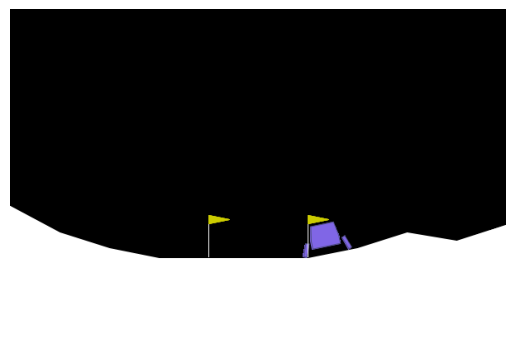

In [40]:
visualize(model, env)

We can see the learned DQN agent is able to land the rocket on the moon properly. This is done with a lot of effort optimizing the hyperparameters.

## Training a Policy Gradient agent

Next, we will train an agent with a policy gradient algorithm. A very popular and tested RL algorithm is Proximal Policy Optimization or PPO.

### about PPO

You might have had a difficult time training the DQN agent with the various available hyperparameters. This is due to the nature of DQN and how it estimates the action values to the rewards (as shown in the equations a bit earlier in the notebook). In some environment, DQN tends to overestimate the reward value of a specific (discrete) action, which then overshoots and leaves the training off-track from the actual optimal policy. PPO tries to mitigate this disadvantage by clipping the action value updates so the agent doesn't overshoot its learning to a specific action.

How it does the clipping is given by the following function:

\begin{align}L^{CLIP}(\theta) = \hat{\mathbb{E_t}}\left[\min(
    r_t(\theta)\hat{A_t},clip(r_t(\theta),1-\in,1+\in)\hat{A_t})
    )\right]\end{align}

In essence, this function samples a batch of data (amount can be tweaked) experienced in the policy network of the environment for a specific number of steps (also can be tweaked), and subsequently clips the policy update to a certain amount (again, also can be tweaked) to lower the return estimates of the action value. This way, a theoretically more stable learning process can be achieved.

Enough of theory; let's move on to the training. We will use the stable_baslines3 implementation of PPO to train the agent. Let's try training with 10.000 steps.


In [ ]:
from stable_baselines3 import PPO

# Make the evironment
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode="rgb_array")

seed = 0

# Train a the DQN agent
model = PPO("MlpPolicy", env, gamma=0.9, seed=seed, verbose=1)
model.learn(total_timesteps=10_000)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"The mean reward is {mean_reward} and the standard deviation of the reward is {std_reward}")

Training 10.000 steps might not be enough for the PPO agent.

#### TO DO 4:
* Tweak the [hyperparameters](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO) of the PPO agent. Which parameters do you think are the most suitable for training the moon lander?
* Train a PPO agent, subsequently evaluate the agent and explain the changes you made.

In [29]:
#fill in values of the hyperparameters below

n_steps = 
hyperparams_ppo = {'batch_size': ,
                   'n_steps': ,
                   'gamma' : ,
                   'clip_range' :
                   }

In [ ]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

# Make the evironment
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode="rgb_array")
env = Monitor(env, log_dir)

seed = 5

# Train a the PPO agent
model = PPO("MlpPolicy", env, seed=seed, verbose=1, **hyperparams_ppo)
model.learn(total_timesteps=n_steps, callback=callback)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"The mean reward is {mean_reward} and the standard deviation of the reward is {std_reward}")

In [ ]:
plot_results([log_dir], n_steps, results_plotter.X_TIMESTEPS, "PPO LunarLander")
plt.show()

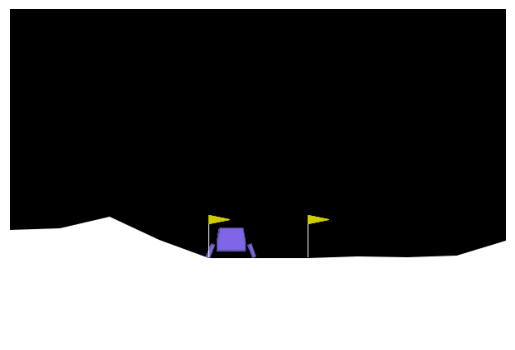

In [32]:
visualize(model, env)

Your best model will be saved in the files section of google colab. This file you can download and run again; or even continue with the training.

Here you have learned to train an RL agent to land a rocket on the moon with two popular RL algorithms. There are some differences between the two algorithms.

#### TO DO 5:
*   What are the main differences between Q-learning and Gradient Policy algorithm?
* What does it mean that DQN learns off-policy and PPO learns on-policy?
* What are your thought about when to use either DQN or PPO?